# **Problem Description:**

In the support process, incoming incidents are analyzed and assessed by organization’s support teams to 
fulfill the request. In many organizations, better allocation and effective usage of the valuable support 
resources will directly result in substantial cost savings. 

 

Currently the incidents are created by various stakeholders (Business Users, IT Users and Monitoring 
Tools) within IT Service Management Tool and are assigned to Service Desk teams (L1 / L2 teams). This 
team will review the incidents for right ticket categorization, priorities and then carry out initial 
diagnosis to see if they can resolve. Around ~54% of the incidents are resolved by L1 / L2 teams. Incase 
L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from 
Applications and Infrastructure (L3 teams). Some portions of incidents are directly assigned to L3 teams 
by either Monitoring tools or Callers / Requestors. L3 teams will carry out detailed diagnosis and resolve 
the incidents. Around ~56% of incidents are resolved by Functional / L3 teams. Incase if vendor support 
is needed, they will reach out for their support towards incident closure. 

L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to 
Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket 
assignment). 15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed 
only for incident assignment to L3 teams.
During the process of incident assignments by L1 / L2 teams to functional groups, there were multiple 
instances of incidents getting assigned to wrong functional groups. Around ~25% of Incidents are 
wrongly assigned to functional teams. Additional effort needed for Functional teams to re-assign to right 
functional groups. During this process, some of the incidents are in queue and not addressed timely 
resulting in poor customer service.

In [0]:
import numpy as np 
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf






In [82]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Anaconda3-5.2.0-Linux-x86_64.sh',
 'Sarcasm_Headlines_Dataset.json',
 'SeqNLP_Project.ipynb',
 'SeqNLP_Project1_Questions.ipynb',
 'sample.json',
 'Sarcasm Detection LSTM.ipynb',
 'Sarcasm_Headlines_Dataset_v2.json',
 'input_data_csv.csv',
 'cleaned_data_csv.gsheet',
 'cleaned_data_csv.csv',
 'cleaned_data_desc.csv',
 'cleaned_data_desc.gsheet',
 'corpus.pkl',
 'dictionary.gensim',
 'model5.gensim.state',
 'model5.gensim.id2word',
 'model5.gensim.expElogbeta.npy',
 'model5.gensim',
 'model3.gensim.id2word',
 'model3.gensim.state',
 'model3.gensim',
 'model3.gensim.expElogbeta.npy',
 'model10.gensim.id2word',
 'model10.gensim.expElogbeta.npy',
 'model10.gensim.state',
 'model10.gensim',
 'capstone_prj_ticketing_system.ipynb',
 'new_capstone_prj_ticketing_system.ipynb']

# **Data Description:**

*Short description:* It gives a very short description of the ticket raised

*Description:* It gives a detailed description of the problem along with additional details like email id of the user etc.

*Caller:* It provides the details of the caller who reported issue

*Assignment group*: CAll center authority who assigns the ticket to a particular group based on his/her understanding

As part of Data Pre Processing, we will be performing cleaning of data (removing duplicates, removing empty rows, removing stop words etc.)

**Lower case and removing stop words** — Convert the entire input description to lower case and remove the stop words as they don’t add anything to the categorization

**Lemmatizing words—** This groups together different inflections of the same words like organize, organizes, organizing, etc.

**n-grams —** Using n-grams we can count the sequence of the words, Instead of counting single words

The original data that we got was unlabelled data and contained only the ticket descriptions with lots of unnecessary groupings. Since the approach selected for this project is classification we needed some mechanism to convert this unlabelled data to labelled data. We need to have some categories defined to which these tickets can be bucketed.We will use Topic Modelling approach for this.

In [0]:
# loading dataset from csv
dfTickets = pd.read_csv(
    'input_data_csv.csv',
    dtype=str
)


In [84]:
#Rename the columns which has space in between
dfTickets.rename(columns = {'Short description':'short_desc'}, inplace = True) 
dfTickets.rename(columns = {'Assignment group':'assignment_group'}, inplace = True) 

dfTickets.head(5)

,short_desc,Description,Caller,assignment_group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


**DATA VISUALIZATION AND PREPROCESSING**

In [85]:
dfTickets.isna().sum() # Checking for NaN values

short_desc          2
Description         1
Caller              0
assignment_group    0
dtype: int64

# Do Plotting of the current Data and show why its not required

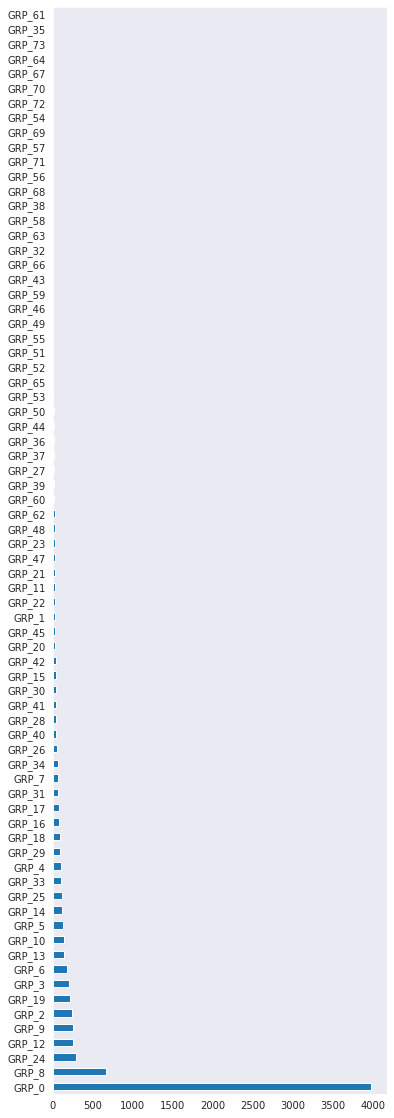

In [86]:
#Plot data based on the existing Groups
sns.set_style("dark")
#sns.countplot(dfTickets.assignment_group, figsize=(40,20))
dfTickets['assignment_group'].value_counts().plot(kind='barh', figsize=(6,20))

In [87]:
summary_by_group = (
    dfTickets
    .groupby('assignment_group')    
    .size()
    .to_frame('Ticket count')
    .reset_index()
)
summary_by_group['assignment_group'] = summary_by_group['assignment_group'].str.replace(' ', '\n')
summary_by_group

,assignment_group,Ticket count
0,GRP_0,3976
1,GRP_1,31
2,GRP_10,140
3,GRP_11,30
4,GRP_12,257
...,...,...
69,GRP_71,2
70,GRP_72,2
71,GRP_73,1
72,GRP_8,661


**Analysis -1**

As its obvious from the above report analysis that there are nearly 74 Groups created in the ticketing process. Its very difficult to understand to which group the ticket needs to be assigned considering so many groups and also the group names does not have any literal meaning.

**Analysis-2**

Cloumns to Drop: 

Assignment Group columns needs to be dropped and a fresh assignment group needs to understood by anayzing the data present in short_description OR Description column

Caller group does not hold any significance as we are analyzing the tickets assignment group, hence this can be dropped

# All Cleaning Functions

In [0]:
#All Cleaning Functions
removedWordsList = (['xxxxx1'])


def removeNonEnglish(text, englishWords):
    global removedWordsList
    wordList = text.split()
    if len(wordList) == 0:
        return " "
    y = np.array(wordList)
    x = np.array(englishWords)
    index = np.arange(len(englishWords))
    sorted_index = np.searchsorted(x, y)
    yindex = np.take(index, sorted_index, mode="clip")
    mask = x[yindex] != y
    maskedArr = np.ma.array(yindex, mask=mask).compressed()
    result = x[maskedArr]
    text = np.array2string(result)\
        .replace("\'", "")\
        .replace("[", "")\
        .replace("]", "")\
        .replace("\n", "")\
        .replace("\r", "")

    # Logging removed words
    removedWords = set(wordList)-set(result)
    removedWordsList += set(list(removedWords))-set(removedWordsList)
    return text

def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')


def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset


def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    # regexList += ['RITM[0-9]*'] # request id
    # regexList += ['INC[0-9]*'] # incident id
    # regexList += ['TKT[0-9]*'] # ticket id
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['The information(.*)infection']  # footer
    regexList += ['Endava Limited is a company(.*)or omissions']  # footer
    regexList += ['The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient']  # footer
    regexList += ['\[cid:(.*)]']  # images cid
    regexList += ['https?:[^\]\n\r]+']  # https & http
    regexList += ['Subject:']
   
    regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
    regexList += ['Subject:']
    regexList += ['received']
    regexList += ['[^a-zA-Z]']

    return regexList

In [89]:
# Create Data Set with Short Description only
del dfTickets['Caller'] # Deleting this column as it is of no use
del dfTickets['assignment_group'] # Deleting this column as there are too many assignment groups, we need to create a new category
del dfTickets['Description']
dfTickets_short_desc = dfTickets
dfTickets_short_desc.head(5)

,short_desc
0,login issue
1,outlook
2,cant log in to vpn
3,unable to access hr_tool page
4,skype error


In [90]:
#Print shape of the Data Set
print(dfTickets_short_desc.shape)

(8500, 1)


In [91]:
# Remove duplicates
columnsToDropDuplicates = ['short_desc']
dfTickets_short_desc = dfTickets_short_desc.drop_duplicates(columnsToDropDuplicates)
print(dfTickets_short_desc.shape)

(7483, 1)


In [92]:
# Select columns for cleaning
columnsToClean = ['short_desc']

# Create list of regex to remove sensitive data
# Clean dataset and remove sensitive data
cleanDataset(dfTickets_short_desc, columnsToClean, getRegexList())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,short_desc
0,login issue
1,outlook
2,cant log in to vpn
3,unable to access hr tool page
4,skype error
...,...
8495,emails not coming in from zz mail
8496,telephony software issue
8497,vip windows password reset for tifpdchb pedx...
8498,machine n o est funcionando


In [93]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
all_words = dfTickets_short_desc['short_desc'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Frequent Occuring word (unclean) in Short Description'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

From the above plot its clearly evident that the headlines need to be cleaned as the top 50 most occuring words are joining words and indirect words which does not provide any meaning.

In [94]:
# Tokenizing the Short Description

short_desc_array = []
for rows in range(0, dfTickets_short_desc.shape[0]):
    txt = dfTickets_short_desc.short_desc[rows]
    txt = txt.split(" ")
    short_desc_array.append(txt)
 

KeyError: ignored

In [95]:
#Print Array
print(short_desc_array)   

[['login', 'issue'], ['outlook'], ['cant', 'log', 'in', 'to', 'vpn'], ['unable', 'to', 'access', 'hr', 'tool', 'page'], ['skype', 'error', ''], ['unable', 'to', 'log', 'in', 'to', 'engineering', 'tool', 'and', 'skype'], ['event', '', 'critical', 'hostname', '', '', '', '', 'company', 'com', 'the', 'value', 'of', 'mountpoint', 'threshold', 'for', '', 'oracle', 'sid', '', '', '', 'erpdata', '', '', '', ''], ['ticket', 'no', '', '', '', '', '', '', '', '', 'employment', 'status', '', '', 'new', 'non', 'employee', '', 'enter', 'user', 's', 'name', ''], ['unable', 'to', 'disable', 'add', 'ins', 'on', 'outlook'], ['ticket', 'update', 'on', 'inplant', '', '', '', '', '', '', ''], ['engineering', 'tool', 'says', 'not', 'connected', 'and', 'unable', 'to', 'submit', 'reports'], ['hr', 'tool', 'site', 'not', 'loading', 'page', 'correctly'], ['unable', 'to', 'login', 'to', 'hr', 'tool', 'to', 'sgxqsuojr', 'xwbesorf', 'cards'], ['user', 'wants', 'to', 'reset', 'the', 'password'], ['unable', 'to', '

In [96]:
#Converting into single list for Short Descriptions
import itertools
short_desc_list = list(itertools.chain(*short_desc_array))
print(short_desc_list)

['login', 'issue', 'outlook', 'cant', 'log', 'in', 'to', 'vpn', 'unable', 'to', 'access', 'hr', 'tool', 'page', 'skype', 'error', '', 'unable', 'to', 'log', 'in', 'to', 'engineering', 'tool', 'and', 'skype', 'event', '', 'critical', 'hostname', '', '', '', '', 'company', 'com', 'the', 'value', 'of', 'mountpoint', 'threshold', 'for', '', 'oracle', 'sid', '', '', '', 'erpdata', '', '', '', '', 'ticket', 'no', '', '', '', '', '', '', '', '', 'employment', 'status', '', '', 'new', 'non', 'employee', '', 'enter', 'user', 's', 'name', '', 'unable', 'to', 'disable', 'add', 'ins', 'on', 'outlook', 'ticket', 'update', 'on', 'inplant', '', '', '', '', '', '', '', 'engineering', 'tool', 'says', 'not', 'connected', 'and', 'unable', 'to', 'submit', 'reports', 'hr', 'tool', 'site', 'not', 'loading', 'page', 'correctly', 'unable', 'to', 'login', 'to', 'hr', 'tool', 'to', 'sgxqsuojr', 'xwbesorf', 'cards', 'user', 'wants', 'to', 'reset', 'the', 'password', 'unable', 'to', 'open', 'payslips', '', 'ticke

**Removing Stopwords**

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words.

We will remove the stopwords provided by NLTK package from our headlines.

In [97]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
short_desc_list_restp = [word for word in short_desc_list if word.lower() not in stopwords]


print("Length of original Short Desc list: {0} words\n"
      "Length of Short Desc list after stopwords removal: {1} words"
      .format(len(short_desc_list), len(short_desc_list_restp)))

print("=="*46)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Length of original Short Desc list: 454 words
Length of Short Desc list after stopwords removal: 374 words


Top 30 Occuring words after removing Stopwords from Short Description

In [0]:
#Data cleaning for getting top 20
from collections import Counter
short_desc_list_cnt = Counter(short_desc_list_restp)


#Dictonary to Dataframe
short_desc_list_cnt_df = pd.DataFrame(list(short_desc_list_cnt.items()), columns = ['Words', 'Freq'])
short_desc_list_cnt_df = short_desc_list_cnt_df.sort_values(by=['Freq'], ascending=False)

#Top 10
short_desc_list_cnt_df_20 = short_desc_list_cnt_df.head(20)


In [101]:
#Plotting the top 20 Short Descriptions
from plotly import tools
shortdesc_tr  = go.Bar(
    x=short_desc_list_cnt_df_30['Freq'],
    y=short_desc_list_cnt_df_30['Words'],
    name='Issues',
    marker=dict(
        color='rgba(155, 89, 182, 0.6)',
        line=dict(
            color='rgba(155, 89, 182, 1.0)',
            width=.3,
        )
    ),
    orientation='h',
    opacity=0.6
)

fig = tools.make_subplots(rows=1, cols=1, subplot_titles=('Top 20 Most occuring words in Ticketing Platform'))

fig.append_trace(shortdesc_tr, 1, 1)

fig['layout'].update(height=600, width=800)

iplot(fig, filename='short_desc')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



**Stemming**

In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form - generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

NLTK provides three different forms of steamming namely Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. Here, for our analysis we will be using Snowball stemmer.

In [102]:
stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)

print("The stemmed form of learning is: {}".format(stemmer.stem("learning")))
print("The stemmed form of learns is: {}".format(stemmer.stem("learns")))
print("The stemmed form of learn is: {}".format(stemmer.stem("learn")))
print("=="*46)
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))
print("=="*46)

The stemmed form of learning is: learn
The stemmed form of learns is: learn
The stemmed form of learn is: learn
The stemmed form of leaves is: leav


Here is the caveat in using stemming. In the above example for the word 'leaves', it just stemms the word. As the name 'stemming' suggest, it at times simply stems the word which will become meaningless. So, to overcome this issue we have lemmatization.

**Lemmatisation**

Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. Unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning.

In [103]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
The lemmatized form of leaves is: leaf


In [0]:
#Short Description after Lemmatization
short_desc_lem = []
for batch in short_desc_array:
    short_desc_list_restp = [word for word in batch if word.lower() not in stopwords]
    lemm = WordNetLemmatizer()
    short_list_lemm =  [lemm.lemmatize(word) for word in short_desc_list_restp]
    short_desc_lem.append(short_list_lemm)



**Bag of Words**

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
vec = []
for block in short_desc_lem:
    vectorizer = CountVectorizer(min_df=0)
    sentence_transform = vectorizer.fit_transform(block)
    vec.append(sentence_transform)
    
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['dly', 'failed', 'job', 'merktc', 'mm', 'scheduler', 'zscr']

The vectorized array looks like:
 [[0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In the above output, I have showed as how the bag of words looks like which is achieved through vectorized operation.

**Play with Bi-grams**

A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. The frequency distribution of every bigram in a string is commonly used for simple statistical analysis of text in many applications, including in computational linguistics, cryptography, speech recognition, and so on.

In [108]:
short_desc_lem_df = pd.DataFrame({'shortdesc':short_desc_lem})

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

#Plotting the Bigram plot
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in short_desc_lem_df["shortdesc"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
sar_2 = horizontal_bar_chart(fd_sorted.head(20), '#9B59B6')

# Creating one subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of Short Description"])
fig.append_trace(sar_2, 1, 1)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots For Short Description after removing Stopwords")

iplot(fig, filename='word-plots')

/usr/local/lib/python3.6/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



                   word  wordcount
0                              111
1               hr tool          7
2          unable login          6
3                  sid           5
4        password reset          4
5               erp sid          4
6              login hr          4
7              inplant           3
8         ticket update          3
9      engineering tool          3
10           scheduler           2
11        job scheduler          2
12           failed job          2
13               failed          2
14      management tool          2
15  password management          2
16           tool etime          2
17             printer           2
18               reset           2
19        check payslip          2


In [109]:
print(fd_sorted.head(20))

                   word  wordcount
0                              111
1               hr tool          7
2          unable login          6
3                  sid           5
4        password reset          4
5               erp sid          4
6              login hr          4
7              inplant           3
8         ticket update          3
9      engineering tool          3
10           scheduler           2
11        job scheduler          2
12           failed job          2
13               failed          2
14      management tool          2
15  password management          2
16           tool etime          2
17             printer           2
18               reset           2
19        check payslip          2
